### Step 1: Data exploration

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
# Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.read_excel(url)

In [154]:
# Dataset checking
print(df.head())
print(df.info())
print(df.describe())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invo

#### Data to clean: 
- canceled transactions
- missing CustomerID

### Step 2: Data cleaning

In [156]:
# Remove cancelled transactions (invoices starting with 'C')
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]

# Handle missing CustomerID
df = df.dropna(subset=['Customer ID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['Price']

# Filter relevant columns
df = df[['Customer ID', 'InvoiceDate', 'Invoice', 'Quantity', 'Price', 'TotalAmount']]

In [186]:
# Display the dataframe
df

,Customer ID,InvoiceDate,Invoice,Quantity,Price,TotalAmount
0,13085.0,2009-12-01 07:45:00,489434,12,6.95,83.40
1,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.00
2,13085.0,2009-12-01 07:45:00,489434,12,6.75,81.00
3,13085.0,2009-12-01 07:45:00,489434,48,2.10,100.80
4,13085.0,2009-12-01 07:45:00,489434,24,1.25,30.00
...,...,...,...,...,...,...
525456,17530.0,2010-12-09 20:01:00,538171,2,2.95,5.90
525457,17530.0,2010-12-09 20:01:00,538171,1,3.75,3.75
525458,17530.0,2010-12-09 20:01:00,538171,1,3.75,3.75
525459,17530.0,2010-12-09 20:01:00,538171,2,3.75,7.50


### Step 3: RFM Analysis

In [160]:
# Step 1: Calculate Recency, Frequency, and Monetary values
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)  # Latest invoice date + 1 day
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

In [162]:
# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [164]:
# Step 2: Assign RFM scores
# Recency: Lower values are better (e.g., 1 for most recent, 5 for least recent)
rfm['RecencyScore'] = pd.qcut(rfm['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')

In [166]:
# Bins for Frequency & Monetary were done manually due to errors (When pd.qcut() tries to create quantiles, it ends up with duplicate bin edges, which is not allowed by default)
# Manual binning for Frequency
frequency_bins = [0, 1, 2, 3, 5, float('inf')]
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=[1, 2, 3, 4, 5])

In [168]:
# Manual binning for Monetary
monetary_bins = [0, 100, 200, 500, 1000, float('inf')]
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=monetary_bins, labels=[1, 2, 3, 4, 5])

In [170]:
# Step 3: Calculate RFM score
rfm['RFM_Score'] = rfm['RecencyScore'].astype(int) + rfm['FrequencyScore'].astype(int) + rfm['MonetaryScore'].astype(int)

ValueError: Cannot convert float NaN to integer

In [174]:
# checking the error (look for NaN)
print(rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].isnull().sum())

RecencyScore      0
FrequencyScore    0
MonetaryScore     2
dtype: int64


In [176]:
# Drop rows with NaN values
rfm = rfm.dropna(subset=['RecencyScore', 'FrequencyScore', 'MonetaryScore'])

In [178]:
# Step 3: Calculate RFM score
rfm['RFM_Score'] = rfm['RecencyScore'].astype(int) + rfm['FrequencyScore'].astype(int) + rfm['MonetaryScore'].astype(int)

In [180]:
# Step 4: Segment customers
rfm['Segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=['Low', 'Medium', 'High'])

In [184]:
# Display the RFM table
rfm

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Segment
0,12346.0,165,11,372.86,2,5,3,10,Medium
1,12347.0,3,2,1323.32,5,2,5,12,Medium
2,12348.0,74,1,222.16,2,1,3,6,Low
3,12349.0,43,3,2671.14,3,3,5,11,Medium
4,12351.0,11,1,300.93,5,1,3,9,Medium
...,...,...,...,...,...,...,...,...,...
4309,18283.0,18,6,641.77,4,5,4,13,High
4310,18284.0,67,1,461.68,3,1,3,7,Low
4311,18285.0,296,1,427.00,1,1,3,5,Low
4312,18286.0,112,2,1296.43,2,2,5,9,Medium


### Step 4: Customer Segmentation (Clustering)

In [189]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [191]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [193]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

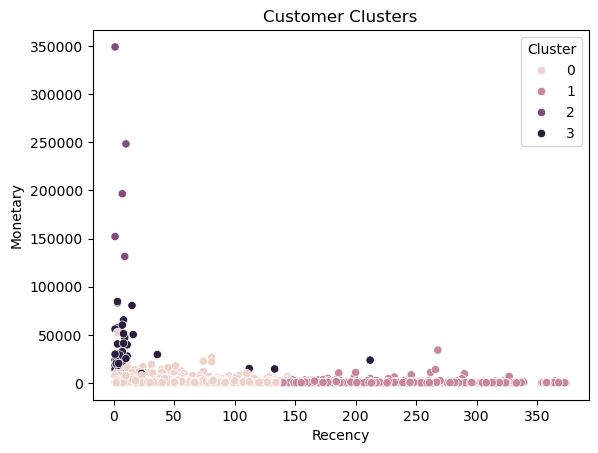

In [195]:
# Visualize clusters
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm)
plt.title('Customer Clusters')
plt.show()

### Step 5: Purchase Pattern Analysis

In [198]:
# Monthly sales trend
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalAmount'].sum()

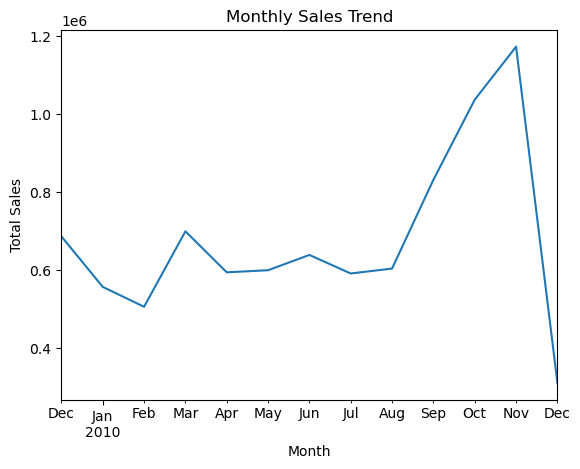

In [200]:
# Plot monthly sales
monthly_sales.plot(kind='line', title='Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

### Step 6: Product Recommendations (Association Rules)

In [251]:
print(df.columns)

Index(['Customer ID', 'InvoiceDate', 'Invoice', 'Quantity', 'Price',
       'TotalAmount', 'InvoiceMonth'],
      dtype='object')


In [255]:
df2 = pd.read_excel(url)

In [257]:
# Remove cancelled transactions (invoices starting with 'C')
df2 = df2[~df2['Invoice'].astype(str).str.contains('C', na=False)]

# Handle missing CustomerID
df2 = df2.dropna(subset=['Customer ID'])

# Convert InvoiceDate to datetime
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])

# Create TotalAmount column
df2['TotalAmount'] = df2['Quantity'] * df2['Price']

In [299]:
# Import required libraries
from mlxtend.frequent_patterns import apriori, association_rules

In [301]:
# Create a transaction matrix
basket = df2.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0)

In [371]:
# Convert quantities to boolean values (True for purchased, False for not purchased)
basket = basket.astype(bool)

# Generate frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

# Display the top 10 rules
print(rules.head(10))

  antecedents consequents  antecedent support  consequent support   support  \
0     (21212)     (84991)            0.079209            0.059120  0.031278   
1     (84991)     (21212)            0.059120            0.079209  0.031278   
2     (21232)     (21231)            0.069477            0.042050  0.032371   
3     (21231)     (21232)            0.042050            0.069477  0.032371   
4    (85123A)     (21733)            0.157221            0.051730  0.037575   
5     (21733)    (85123A)            0.051730            0.157221  0.037575   

   confidence       lift  representativity  leverage  conviction  \
0    0.394875   6.679160               1.0  0.026595    1.554852   
1    0.529049   6.679160               1.0  0.026595    1.955175   
2    0.465918  11.079959               1.0  0.029449    1.793636   
3    0.769802  11.079959               1.0  0.029449    4.042272   
4    0.238994   4.619984               1.0  0.029442    1.246073   
5    0.726358   4.619984              

In [373]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(21212),(84991),0.079209,0.059120,0.031278,0.394875,6.679160,1.0,0.026595,1.554852,0.923424,0.292173,0.356852,0.461962
1,(84991),(21212),0.059120,0.079209,0.031278,0.529049,6.679160,1.0,0.026595,1.955175,0.903708,0.292173,0.488537,0.461962
2,(21232),(21231),0.069477,0.042050,0.032371,0.465918,11.079959,1.0,0.029449,1.793636,0.977673,0.408941,0.442473,0.617860
3,(21231),(21232),0.042050,0.069477,0.032371,0.769802,11.079959,1.0,0.029449,4.042272,0.949682,0.408941,0.752614,0.617860
4,(85123A),(21733),0.157221,0.051730,0.037575,0.238994,4.619984,1.0,0.029442,1.246073,0.929721,0.219253,0.197479,0.482676
5,(21733),(85123A),0.051730,0.157221,0.037575,0.726358,4.619984,1.0,0.029442,3.079862,0.826294,0.219253,0.675310,0.482676


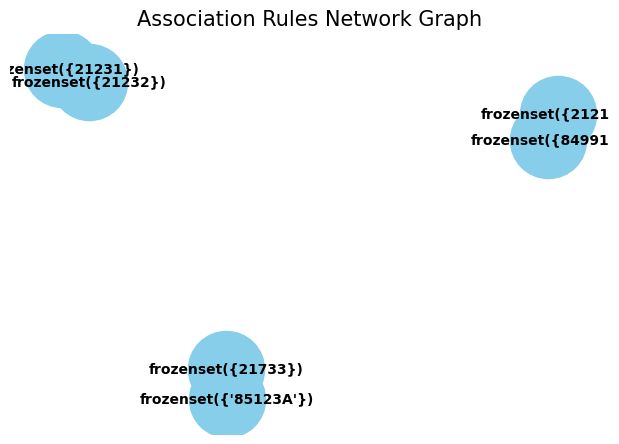

In [381]:
# Result visualization
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges (rules) to the graph
for _, rule in rules.iterrows():
    G.add_edge(rule['antecedents'], rule['consequents'], weight=rule['lift'])

# Draw the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, k=0.5)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=[G[u][v]['weight'] for u, v in G.edges()])
plt.title('Association Rules Network Graph', fontsize=15)
plt.show()

In [383]:
# Create a pivot table for lift values
pivot_table = rules.pivot(index='antecedents', columns='consequents', values='lift')

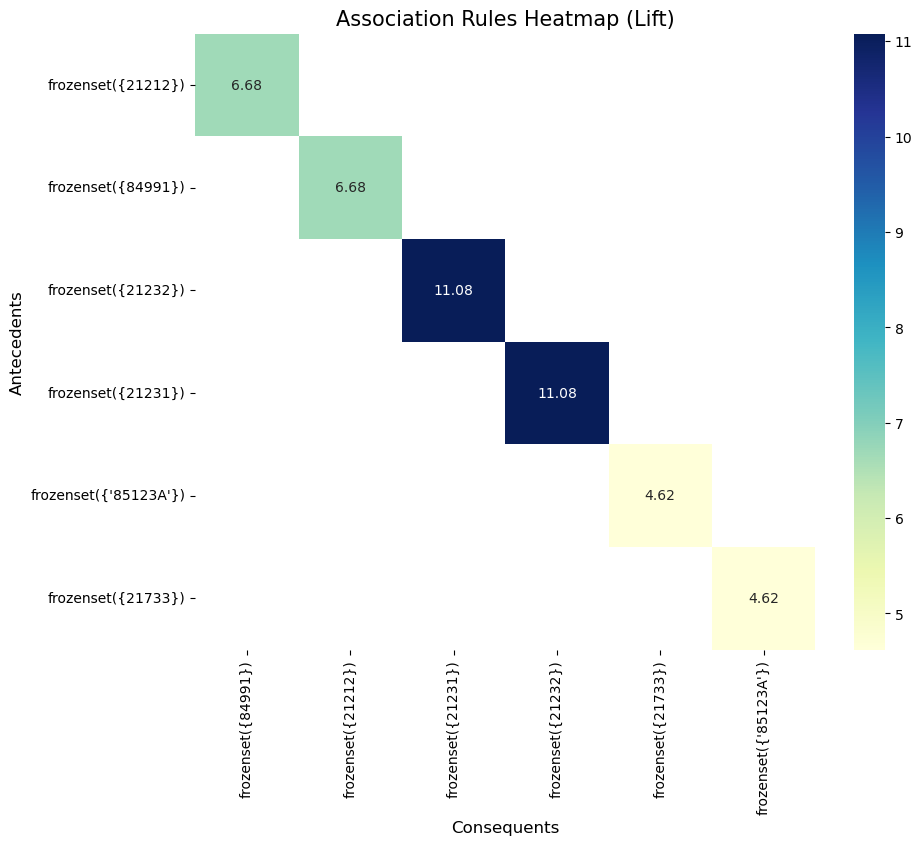

In [385]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Association Rules Heatmap (Lift)', fontsize=15)
plt.xlabel('Consequents', fontsize=12)
plt.ylabel('Antecedents', fontsize=12)
plt.show()

### Step 7: Predictive Modelling (Customer Lifetime Value)

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [233]:
# Feature engineering for CLV
clv_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

In [237]:
# Rename columns
clv_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [239]:
# Define target variable (CLV)
clv_data['CLV'] = clv_data['Monetary'] * clv_data['Frequency']

# Display the CLV data
print(clv_data.head())

   CustomerID  Recency  Frequency  Monetary      CLV
0     12346.0      165         11    372.86  4101.46
1     12347.0        3          2   1323.32  2646.64
2     12348.0       74          1    222.16   222.16
3     12349.0       43          3   2671.14  8013.42
4     12351.0       11          1    300.93   300.93


In [241]:
# Feature engineering for CLV
X = clv_data[['Recency', 'Frequency', 'Monetary']]
y = clv_data['CLV']

In [243]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [247]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 569572054196.656


##### Mean squared error is too large, indicating the model's predictions are significantly different from the actual values

In [269]:
# Log transformation of CLV
clv_data['CLV_log'] = np.log1p(clv_data['CLV'])

In [275]:
# Feature engineering
clv_data['AvgOrderValue'] = clv_data['Monetary'] / clv_data['Frequency']
clv_data['Tenure'] = (snapshot_date - df.groupby('Customer ID')['InvoiceDate'].min()).dt.days

In [277]:
# Define features and target
X = clv_data[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'Tenure']]
y = clv_data['CLV_log']

In [279]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [285]:
# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [287]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.006026228665495981


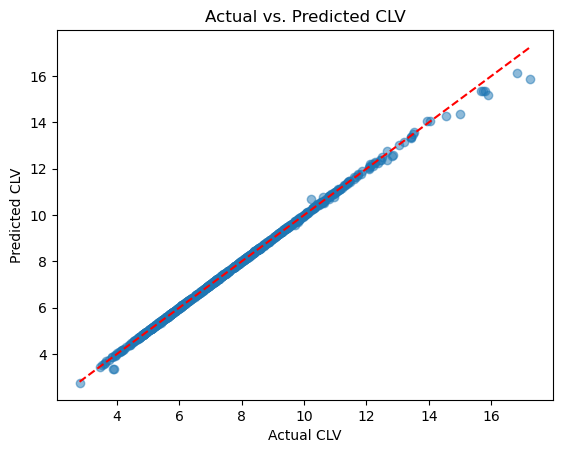

In [297]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Actual vs. Predicted CLV')
plt.show()